<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notes" data-toc-modified-id="Notes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notes</a></span><ul class="toc-item"><li><span><a href="#Journal" data-toc-modified-id="Journal-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Journal</a></span></li><li><span><a href="#To-Do" data-toc-modified-id="To-Do-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>To Do</a></span></li><li><span><a href="#Musings" data-toc-modified-id="Musings-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Musings</a></span></li></ul></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train</a></span><ul class="toc-item"><li><span><a href="#Init" data-toc-modified-id="Init-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Training-sessions" data-toc-modified-id="Training-sessions-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Training sessions</a></span><ul class="toc-item"><li><span><a href="#What-worked" data-toc-modified-id="What-worked-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>What worked</a></span></li><li><span><a href="#What-didn't-work" data-toc-modified-id="What-didn't-work-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>What didn't work</a></span><ul class="toc-item"><li><span><a href="#Overfit-fine-tune" data-toc-modified-id="Overfit-fine-tune-4.2.2.1"><span class="toc-item-num">4.2.2.1&nbsp;&nbsp;</span>Overfit fine tune</a></span></li><li><span><a href="#Test-fine_tune-method" data-toc-modified-id="Test-fine_tune-method-4.2.2.2"><span class="toc-item-num">4.2.2.2&nbsp;&nbsp;</span>Test fine_tune method</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Results-and-Metrics" data-toc-modified-id="Results-and-Metrics-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results and Metrics</a></span><ul class="toc-item"><li><span><a href="#Viz-results" data-toc-modified-id="Viz-results-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Viz results</a></span></li><li><span><a href="#Investigating-low-performance" data-toc-modified-id="Investigating-low-performance-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Investigating low performance</a></span><ul class="toc-item"><li><span><a href="#Deeper-architecture?" data-toc-modified-id="Deeper-architecture?-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Deeper architecture?</a></span></li></ul></li></ul></li></ul></div>

# Notes

The purpose of this notebook is to learn how to fine-tune my learner with fastai's built-in methods. I'll also be moving to the COCO_SAMPLE dataset so I can speed up the training loops.

## Journal

- 2020-12-09 (Wed):
    - Created nb
    - Accomplishment: I figured out how to use a resnet50 backbone
    - I'm concerned that the results are pretty poor. I made a note to figure out why the predictions for remote are especially bad. Is it just that this dataset doesn't have people..?
    - The fastai 2018 course implementation of SSD achieved **.30** mAP on the PASCAL VOC 2007 dataset ([link here](https://forums.fast.ai/t/mean-average-precision-map/14345/16?u=mccallionr)). This makes me think I should aim for an mAP of .5 on the same dataset.

## To Do

**Main things**
- 🟢 Move to COCO_SAMPLE in order to speed up training
- 🟡 Train & fine-tune resnet34 to the best of my ability using only fastai's train methods
    - Review fastbook and course to figure out how to squeeze out some extra performance
    - 🟡 because I did a lot of testing but wasn't able to improve on fit_one_cycle.
    - I can still try fine_tune(5, frozen_epochs=2, base_lr=lr), but I do not think I'll get better results.
- 🟢 Unexpected: I was able to figure out how to use a resnet50 base instead of a resnet34!!!
    

**Laundry**
- Refactor ap_per_cls for use in metric and in ResultShower
- Consider refactoring SSD loss to use acts_to_preds
- show_bb should output colored text
- Set all devices in one go
- Change dls.vocab to be voc or v in places

## Musings

**The anchor box approach**

The idea is to subdivide the image into chunks so we can essentially do many single bbox learners instead of one big multibox. To do this, each image must be subdivided into a grid (or multiple grids), and the labels must be remapped to individual grid cells.

Subdivide the image into cells with a grid. For each cell, generate any number of boxes from it so long as those boxes do not have a higher IOU between them and any other grid cell – the generated boxes must be able to be traced back to their grid cell via IOU. For each box generated, have it perform a 'single labeled bbox' task. Each box generated will produce one result. Keep only the most confident results & prune out any that overlap excessively.

# Data

In [ ]:
from fastai.vision.all import *

### Params ###
im_sz   = 224
bs      = 64
val_pct = .1

path = untar_data(URLs.COCO_SAMPLE)
fns, annos = get_annotations(path/'annotations/train_sample.json')
fn2anno = {f:a for f,a in zip(fns,annos)}
def get_im(f):   return Path(path/'train_sample'/f)
def get_bbox(f): return fn2anno[f][0]
def get_lbl(f):  return fn2anno[f][1]

In [ ]:
### DataBlock & DataLoaders ###
db = DataBlock(
    blocks=[ImageBlock, BBoxBlock, BBoxLblBlock],
    get_x=get_im, get_y=[get_bbox, get_lbl],
    splitter=RandomSplitter(val_pct),
    item_tfms=Resize(im_sz, method='squish'),
    batch_tfms=Normalize.from_stats(*imagenet_stats), n_inp=1)
dls = db.dataloaders(fns, bs=bs)
voc = dls.vocab
n_cls = len(voc)
voc

(#7) ['#na#','book','chair','couch','remote','tv','vase']

In [ ]:
### Inspection (IMPORTANT) ###
print("Size of train data:",len(dls.train.items))
print("Size of valid data:",len(dls.valid.items))
for i,t in enumerate(dls.one_batch()):
    print(f"batch[{i}]:",'\t',t.dtype,'\t',t.shape)

Size of train data: 19654
Size of valid data: 2183
batch[0]: 	 torch.float32 	 torch.Size([64, 3, 224, 224])
batch[1]: 	 torch.float32 	 torch.Size([64, 20, 4])
batch[2]: 	 torch.int64 	 torch.Size([64, 20])


Interpretation of tensor shapes:
- torch.Size([128, 3, 224, 224]): bs, channels (rgb), im_sz, im_sz
- torch.Size([128, 20, 4]): bs, max objs for a single im in batch, bb coords
- torch.Size([128, 20]): bs, max objs for a single im in batch

# Model

In [ ]:
### Architecture ###
def perm(x,k):
    return x.permute(0,3,2,1).contiguous().view(x.size(0),x.size(2)*x.size(3)*k,x.size(1)//k)
class StdConv(Module):
    """(42:00) Wraps together the standard conv2d → batchnorm → dropout."""
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)

    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
class OutConv(Module):
    """Takes nin inputs, outputs two layers: one for bbs, one for lbls."""
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.bb_acts  = nn.Conv2d(nin, 4*k, 3, padding=1)             
        self.lbl_acts = nn.Conv2d(nin, len(dls.vocab)*k, 3, padding=1)
        self.lbl_acts.bias.data.zero_().add_(bias)
    
    def forward(self, x):
        return [perm(self.bb_acts(x), self.k),
                perm(self.lbl_acts(x),self.k)]         
class SSDHead(Module):
    """Wraps StdConv and OutConv into a head module."""
    def __init__(self, k, bias, drop):
        super().__init__()
        self.drop  = nn.Dropout(drop)
        self.conv0 = StdConv(512,256, drop=drop) # most grid cells (4x4 for sz=224)
        self.out0  = OutConv(k,  256, bias)
        self.conv1 = StdConv(256,256, drop=drop)
        self.out1  = OutConv(k,  256, bias)
        self.conv2 = StdConv(256,256, drop=drop) # fewest grid cells (1x1 for sz=224)
        self.out2  = OutConv(k,  256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.conv0(x)
        bb0,lbl0 = self.out0(x)
        x = self.conv1(x)
        bb1,lbl1 = self.out1(x)
        x = self.conv2(x)
        bb2,lbl2 = self.out2(x)
        return [torch.cat([ bb0, bb1, bb2], dim=1),
                torch.cat([lbl0,lbl1,lbl2], dim=1)]
class CustomModule(Module):
    """Simple class for joining two modules (a 'head' and a 'body') into one."""
    def __init__(self, body, head):
        self.body, self.head = body, head
        
    def forward(self, x):
        return self.head(self.body(x))


### Create Anchors ###
def create_anchors(subdivs, zooms, ratios, device='cuda'):
    # create list of permutations per default anchor box
    perms = [(z*r1,z*r2) for z in zooms for (r1,r2) in ratios]
    k = len(perms)
    offsets = [1/(sd*2) for sd in subdivs]
    xs = np.concatenate([np.repeat(np.linspace(o, 1-o, sd), sd) for o,sd in zip(offsets, subdivs)])
    ys = np.concatenate([np.tile  (np.linspace(o, 1-o, sd), sd) for o,sd in zip(offsets, subdivs)])
    ctrs = np.repeat(np.stack([xs,ys], axis=1), k, axis=0)
    hws = np.concatenate([np.array([[o/sd,p/sd] for i in range(sd*sd) for o,p in perms]) for sd in subdivs])
    box_sizes = tensor(np.concatenate([np.array([1/sd for i in range(sd*sd) for o,p in perms])
                                      for sd in subdivs]), requires_grad=False).unsqueeze(1)
    anchors = tensor(np.concatenate([ctrs, hws], axis=1), requires_grad=False).float()
    return anchors.to(device), box_sizes.to(device)
def create_anchor_boxes(ctr, hw):
    return 2*torch.cat((tensor(ctr-hw/2), tensor(ctr+hw/2)), axis=1)-1


### mae, BCE_Loss, and FocalLoss ###
def mae(t1, t2):
    return ((t1 - t2).abs()).mean()
def one_hot_embedding(lbls, n_cls):
    return torch.eye(n_cls)[lbls.data.long()].cuda()
class BCELoss(nn.Module):
    def __init__(self, n_cls):
        super().__init__()
        self.n_cls = n_cls
        
    def forward(self, act_lbl, targ_lbl):
        a = act_lbl[:,1:]
        t = one_hot_embedding(targ_lbl, self.n_cls)
        t = tensor(t[:,1:].contiguous())
        w = self.get_weight(a,t)
        return F.binary_cross_entropy_with_logits(a,t,None,reduction='sum')/self.n_cls
    
    def get_weight(self,a,t): return None 
class FocalLoss(BCELoss):
    def get_weight(self, a, t):
        alpha, gamma = 0.25, 2.0 # vals from paper
        p = a.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)
    

### iou ###
def intersxn(b1,b2):
    x1 = torch.max((b1)[:,None,0], (b2)[None,:,0])
    y1 = torch.max((b1)[:,None,1], (b2)[None,:,1])
    x2 = torch.min((b1)[:,None,2], (b2)[None,:,2])
    y2 = torch.min((b1)[:,None,3], (b2)[None,:,3])
    return torch.clamp((x2-x1), min=0) * torch.clamp((y2-y1), min=0)
def area(b):
    return (b[:,2]-b[:,0]) * (b[:,3]-b[:,1])
def get_iou(b1, b2):
    inter = intersxn(b1,b2)
    union = area(b1).unsqueeze(1) + area(b2).unsqueeze(0) - inter
    return inter / union


### ssd_loss ###
def remove_padding(bb, lbl):
    bb = bb.view(-1,4)
    padding = (bb[:,2]-bb[:,0])==0
    return bb[~padding],lbl[~padding]
def get_pred_bbs(act_bb, ancs, anc_sz, device):
    ancs.to(device); anc_sz.to(device)
    acts = torch.tanh(act_bb)                   # make acts between -1 and 1
    ctrs = ancs[:,:2] + (acts[:,:2]/2 * anc_sz) # move ctrs by up to box_size/2
    hws  = ancs[:,2:] * (acts[:,2:]/2+1)        # adjust hw up to 1/2
    return create_anchor_boxes(ctrs, hws)
def map_to_gt(ious):
    max_iou_per_bb, anc_idxs = ious.max(1)
    max_iou_per_anc, bb_idxs = ious.max(0)
    max_iou_per_anc[anc_idxs] = 1.99
    for i,iou in enumerate(anc_idxs): bb_idxs[iou] = i
    return bb_idxs, max_iou_per_anc
def ssd_item_loss(act_bbs, act_lbls, bbs, lbls):
    """SSD item loss takes single items from a minibatch, creates hundreds of preds, maps gt
       to the preds, prunes the preds, then calcs & returns the bb and lbl loss for that item.
       bb_loss and lbl_loss must both be instantiated before this is."""
    # prep
    bbs,lbls = remove_padding(bbs,lbls)                  # remove gt padding inserted during training
    pred_bbs = get_pred_bbs(act_bbs, anchors, box_size, 'cuda') # assemble the ~200 pred bbs from acts and ancs
    # map gt to preds
    iou_gt_grid = get_iou(bbs.data, anchor_boxes.data)   # get iou(gt_bbs,anc_bbs); used to map gt → ancs
    mapped_gt_idx, iou_gt_preds = map_to_gt(iou_gt_grid) # assign each pred an index of a gt object
    mapped_bbs  = bbs[mapped_gt_idx]                     # project gt bbs into pred space
    mapped_lbls = lbls[mapped_gt_idx]                    # project gt lbls into pred space
    # remove low-iou bb preds & set mapped lbl to bg
    high_iou = iou_gt_preds > 0.4                        # only include bb preds that overlap w/a gt obj and
    incl = torch.nonzero(high_iou)[:,0]                  #  are not predicting background
    mapped_lbls[~high_iou] = 0                           # assign gt class of bg to preds w/ low max gt iou
    # compute loss
    bb_loss_val  = bb_loss(pred_bbs[incl], mapped_bbs[incl])
    lbl_loss_val = lbl_loss(act_lbls, mapped_lbls)
    return bb_loss_val, lbl_loss_val
def ssd_loss(b_acts, b_bbs, b_lbls):
    sum_bb_loss, sum_lbl_loss = 0., 0.
    for o in zip(*b_acts, b_bbs, b_lbls):
        bb_loss, lbl_loss = ssd_item_loss(*o)
        sum_bb_loss  += bb_loss
        sum_lbl_loss += lbl_loss
    return sum_bb_loss + sum_lbl_loss


### Utils for converting acts to preds ###
def nms(boxes, scores, min_iou=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort asc
    idx = idx[-top_k:]       # indices of k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= min_iou
        idx = idx[IoU.le(min_iou)]
    return keep, count
def acts_to_preds(abb, albl, ancs, anc_sz, min_iou=.5, min_conf=.2, device='cuda'):
    """Turn model acts into preds: abbs use get_pred_bbs, and albls use sigmoid().max().
       Used in ResultShower and mAP (and could possibly be used in loss fxn)."""
     # convert acts to preds
    pbb = get_pred_bbs(abb, ancs, anc_sz, device)
    conf, plbl = albl.sigmoid().max(1)
    # filter out preds w/ nms
    nms_idxs, nms_n = nms(pbb.data, conf, min_iou)
    nms_idxs = nms_idxs[:nms_n]
    pbb  = pbb[nms_idxs]
    plbl = plbl[nms_idxs]
    conf = conf[nms_idxs]
    # filter out bg and low-conf preds
    is_not_bg = (plbl!=0)
    is_confident = conf > min_conf
    mask = is_not_bg & is_confident
    return pbb[mask], plbl[mask], conf[mask]
def get_batch_preds(abb, albl, ancs, anc_sz, device='cuda'):
    """Loop through a batch and of activations and turn them into predictions."""
    ancs.to(device); anc_sz.to(device)
    pbbs, plbls, confs = [], [], []
    for abb, albl in zip(abb, albl):
        pbb, plbl, conf = acts_to_preds(abb, albl, ancs, anc_sz, device=device)
        pbbs  += [pbb]
        plbls += [plbl]
        confs += [conf]
    return pbbs, plbls, confs

In [ ]:
### Metric ###
def _format_inps(acts, batch, anchors, box_size):
    """Format acts and targs for AP score calc. Input expects learner.acts & learner.batch,
       output format: (im_idx, pred_bbs, pred_cls, cls_conf) and (im_idx, bbs, cls).
       Ex: (46.0, tensor([0.1, 0.2, 0.9, 0.9]), tensor(3), tensor(0.78))"""
    preds = get_batch_preds(*acts, anchors, box_size)
    pred_idxs = torch.cat([torch.tensor([i]*len(o)) for i,o in enumerate(preds[0])])
    pred_idxs = pred_idxs.numpy().tolist()
    gt_idxs   = torch.cat([torch.tensor([i]*len(o)) for i,o in enumerate(batch[1])])
    gt_idxs   = gt_idxs.numpy().tolist()
    batch_preds = list(zip(pred_idxs, *[torch.cat(o) for o in preds]))
    batch_gts   = list(zip(gt_idxs,   *[o.flatten(end_dim=1) for o in batch[1:]]))
    return batch_preds, batch_gts
def _flatten_list(l, ret_L=False):
    """Flatten a list-of-lists; lists can be python `list`s or a fastai `L`s."""
    def _recur(l,res):
        for o in l:
            if   isinstance(o,list): _recur(o,res)
            elif isinstance(o,L)   : _recur(o,res)
            else: res.append(o)
        return res
    res = _recur(l, [])
    return res if not ret_L else L(res)
def _get_tp_bbs(preds_tp):
    """Output list of tp bbs per im in batch. Not used to calculate mAP; only
       used to grab true positive bb preds for visualizing in ResultShower."""
    
    # Each row in preds_tps is a formatted pred (see format_ap_inputs) and a list of
    # 1s and 0s (signifying tps and fps) for a cls. No preds for a cls → empty lists.
    
    batch_idxs, pred_bbs, tpfps = [], [], []
    for preds,tp in preds_tp:
        batch_idxs.append([o[0] for o in preds])
        pred_bbs.append([o[1] for o in preds])
        tpfps.append(tp)
    flat_idxs  = _flatten_list(batch_idxs)
    flat_bbs   = _flatten_list(pred_bbs)
    flat_tpfps = torch.cat(tpfps)

    scored_preds = list(zip(flat_idxs, flat_bbs, flat_tpfps))
    true_bbs = [(int(o[0]), o[1]) for o in scored_preds if o[2]==True]

    true_preds = [torch.zeros(4).view(1,4) for i in range(0,bs)]
    for i,bb in true_bbs:
        if true_preds[i].sum()==0: true_preds[i] = bb.view(1,4)
        else: true_preds[i] = torch.cat([true_preds[int(i)], bb.view(1,4)], dim=0)
    return true_preds
def ap_per_cls(acts, batch, n_cls, ancs, anc_sz, iou_thresh=.5, device='cuda'):
    """Calculate AP score per class. Returns avg AP over all classes."""
    batch_preds, batch_gts = _format_inps(acts, batch, ancs.to(device), anc_sz.to(device))
    # avg_precs holds ap per cls; other accumulators only used for vizing results
    avg_precs, preds_tp, n_objs_accum = [],[],[] 
    for c in range(1,n_cls): # start at 1 to ignore gt
        # store preds and gts for current cls
        preds = [b for b in batch_preds if b[2]==c]
        gts   = [b for b in batch_gts   if b[2]==c]
                
        # sort preds by conf desc
        preds.sort(key=lambda x: x[3], reverse=True)
        
        # make dict of im_idx:zeros(n_objs)
        n_objs = Counter([gt[0] for gt in gts])
        for k,v in n_objs.items(): n_objs[k] = torch.zeros(v)
        
        # init tp: a bool tensor for each im s.t. 1s indicate a pred is a tp
        tp = torch.zeros((len(preds))).bool()
        total_gt_objs = len(gts)
        
        for pred_idx, pred in enumerate(preds):
            gt_objs = [o for o in gts if o[0] == pred[0]]
            n_gt_objs = len(gt_objs)
            max_iou = 0
            
            for idx, gt in enumerate(gt_objs):
                iou = get_iou(pred[1].view(1,4), gt[1].view(1,4))
                if iou > max_iou: max_iou, idx_of_max = iou, idx
                    
            # update idx of gt_obj to indicate it's been used
            if max_iou > iou_thresh:
                if n_objs[pred[0]][idx_of_max]==0:
                    tp[pred_idx] = 1
                    n_objs[pred[0]][idx_of_max] = 1
                    
        # store tp_bbs: use tp ask mask on preds and take 1th item (the bb) from each
        preds_tp.append(([preds,tp]))
        n_objs_accum.append(n_objs)
        
        # calc avg_prec and store
        tps = torch.cumsum(tp, dim=0)               # 1. tp csum: [0,1,1,0,0] → [0,1,2,2,2]
        fps = torch.cumsum(~tp, dim=0)              # (basically same steps for fp)
        prec = torch.div(tps, (tps + fps + 1e-6))   # 2. divide each tps item by n_preds
        prec = torch.cat((torch.tensor([1]), prec)) # 3. slap on a 1 at the beginning
        rec = tps / (total_gt_objs + 1e-6)
        rec = torch.cat((torch.tensor([0]), rec))
        avg_prec = torch.trapz(prec, rec) # calc AP w/ trap rule
        avg_precs.append(avg_prec)        # store AP of this cls in accum
    return avg_precs, _get_tp_bbs(preds_tp), n_objs_accum
class MeanAveragePrecision(Metric):
    
    def __init__(self, func, n_cls): self.func,self.n_cls = func,n_cls
        
    def reset(self): self.res = []
        
    def accumulate(self, learn):
        # store n_iter for use in self.value
        self.n_iter = learn.n_iter
        # calc cls_aps and append result to self.res
        cls_aps,_,_ = self.func(learn.pred, (*learn.xb,*learn.yb), self.n_cls, anchors, box_size, device='cuda')
        self.res.append(cls_aps)
        
    @property
    def value(self):
        return sum(torch.stack([tensor(o) for o in self.res]).sum(axis=0)/self.n_iter)/(self.n_cls-1)
    
    @property
    def name(self): return "mAP"

In [ ]:
### show_bb and ResultShower ###
def show_bb(im, bb=None, lbl=[''], sz=im_sz, figsz=5, color='white', ctx=None, title=None):
    # process empties and nones
    if bb.shape[-1]==0 or bb==None: bb  = tensor([[0.,0,0,0]])
    if lbl==['']:                   lbl = ['']*bb.shape[0]
        
    # process tensors to take advantage of fastai show methods
    bbox = TensorBBox((bb+1)*sz//2)
    labeledbbox = LabeledBBox(bbox,lbl)
    
    if ctx:     show_image(im, figsize=[figsz,figsz], title=title, ctx=ctx)
    else: ctx = show_image(im, figsize=[figsz,figsz], title=title)
    
    labeledbbox.show(ctx=ctx)       # first, draw white lbl bbs...
    bbox.show(ctx=ctx, color=color) # ... then overlay color bbs.
    return ctx
class ResultShower():
    def __init__(self, dls, lrn, ancs, anc_sz):
        # store init's args
        self.dls    = dls
        self.mod    = lrn.model.eval()
        self.ancs   = ancs.cpu()
        self.anc_sz = anc_sz.cpu()
        # compute attributes
        self.batch    = next(iter(self.dls.cpu().valid))
        self.acts     = [a.data for a in self.mod.cpu()(self.batch[0])]
        self.preds    = get_batch_preds(*self.acts, self.ancs, self.anc_sz, device='cpu')
        self.dec_ims  = self.dls.decode(self.batch)[0]
        self.im_sz    = self.batch[0].shape[-1]
        self.v        = self.dls.vocab
        self.last_res = 0
        self.figsize  = [12,12]
        # compute metrics
        self.ap_scores,self.tp_bbs,self.nobj = ap_per_cls(self.acts,self.batch,len(self.v),self.ancs,self.anc_sz,device='cpu')
        # clean up
        self.dls.cuda(); self.mod.cuda()
        
    def __call__(self, *args, **kwargs):
        return self.show_next(*args, **kwargs)
    
    def __getitem__(self, i):
        # get everything to draw
        _,bbs,lbls      = self.batch
        pbbs,plbls,conf = self.preds
        tbbs            = self.tp_bbs
        ims             = self.dec_ims
        # draw
        ctx = get_grid(2, figsize=self.figsize)
        show_bb(ims[i], bbs[i],   self.v[lbls[i]],  sz=self.im_sz, ctx=ctx[0]);
        show_bb(ims[i], pbbs[i],  self.v[plbls[i]], sz=self.im_sz, ctx=ctx[1], color='magenta');
        show_bb(ims[i], tbbs[i],                    sz=self.im_sz, ctx=ctx[1], color='lime')
                 
    def show_next(self, n=1):
        for i in range(n): self[i + self.last_res]
        self.last_res += n

Just coded the above; next step is to test it out in training loop.

# Train

## Init

In [ ]:
# init anchors
subdivs = [4, 2, 1]
zooms   = [0.75, 1.0, 1.3]
ratios  = [(1.,1.), (1.,.5), (.5,1)]
k = len(zooms) * len(ratios)
anchors, box_size = create_anchors(subdivs, zooms, ratios)
anchor_boxes = create_anchor_boxes(anchors[:,:2], anchors[:,2:])

# loss, metric
bb_loss  = mae
lbl_loss = FocalLoss(n_cls)
metric = MeanAveragePrecision(ap_per_cls, n_cls)

In [ ]:
def get_fresh_model():
    return CustomModule(create_body(resnet34,pretrained=True), SSDHead(k,-4.,drop=.4))
model = get_fresh_model()

## Training sessions

### What worked

**Intentional overfitting**

lr: 0.002208673534914851


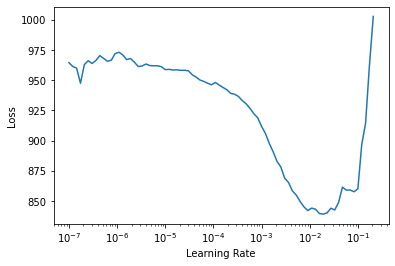

In [ ]:
learner = Learner(dls, model, loss_func=ssd_loss)
learner.freeze()
lr_min, lr_steep = learner.lr_find()
lr = (lr_min+lr_steep)/2; print("lr:",lr)

In [ ]:
learner.fit_one_cycle(10, lr=lr)

epoch,train_loss,valid_loss,time
0,625.896057,557.274353,01:19
1,536.333496,577.466675,01:19
2,495.179443,532.275696,01:20
3,450.106445,509.985443,01:20
4,394.752197,476.629730,01:20
5,336.475433,482.918915,01:20
6,287.882843,480.037048,01:20
7,247.106430,485.303131,01:20
8,219.392563,498.990784,01:20
9,205.873871,504.692627,01:20


Result:
- The model learned for five epochs and started overfitting on the sixth.
- Min valid loss: 477 at 5th epoch

**Stop before overfitting**

Notes:
- I have to reset the model to try again. I was incorrectly just resetting the learner.
- I added to_fp16() to the learner to speed it up.

In [ ]:
model = get_fresh_model()
learner = Learner(dls, model, loss_func=ssd_loss).to_fp16()
learner.freeze()
learner.fit_one_cycle(5, lr=lr)

epoch,train_loss,valid_loss,time
0,605.265015,574.972656,01:11
1,531.143372,522.932556,01:10
2,462.658966,474.097565,01:11
3,380.669403,450.457458,01:11
4,317.987823,449.871643,01:11


In [ ]:
learner.save('s1')

Path('models/s1.pth')

In [ ]:
# learner.export('models/20201209_cocosample.pkl')

### What didn't work

**More Fitting**

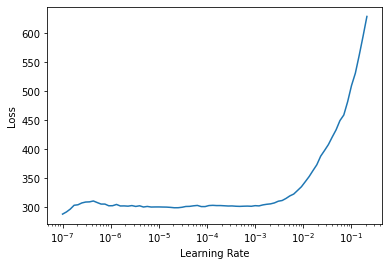

In [ ]:
learner.load('s1')
lr_min, lr_steep = learner.lr_find()
lr = (lr_min+lr_steep)/2

#### Overfit fine tune

In [ ]:
learner.fit_one_cycle(10, lr=1e-5)

epoch,train_loss,valid_loss,time
0,305.708801,478.057922,01:10
1,363.180847,540.423523,01:10
2,379.011597,510.066467,01:10
3,338.863434,530.672180,01:10
4,298.203583,511.813904,01:10
5,261.342163,537.601990,01:10
6,225.196381,535.421082,01:10
7,193.298981,535.590271,01:10
8,166.795776,554.840271,01:11
9,154.718399,563.557190,01:10


In [ ]:
learner.save('s2')

Path('models/s2.pth')

Result: overfitting started immediately. In fastbook.05_pet_breeds, Jeremy says this, which I think may explain this result:

> Before the days of 1cycle training it was very common to save the model at the end of each epoch, and then select whichever model had the best accuracy out of all of the models saved in each epoch. This is known as early stopping. However, this is very unlikely to give you the best answer, because those epochs in the middle occur before the learning rate has had a chance to reach the small values, where it can really find the best result. Therefore, if you find that you have overfit, what you should actually do is retrain your model from scratch, and this time select a total number of epochs based on where your previous best results were found.

#### Test fine_tune method

In [ ]:
model = get_fresh_model()
learner = Learner(dls, model, loss_func=ssd_loss).to_fp16()
learner.freeze()
learner.fine_tune(5, lr=3e-3)

epoch,train_loss,valid_loss,time
0,616.961853,658.466736,01:09


epoch,train_loss,valid_loss,time
0,511.842712,528.635193,01:10
1,491.865387,531.903259,01:10
2,434.218170,474.593475,01:10
3,355.450592,470.052216,01:10
4,301.787781,469.717072,01:10


Result: almost achieved accuracy of foc(5,lr).

Notes:
- base_lr is the correct "normal" lr to set with fine_tune
- discriminitive lrs are applied during deep training (min is lr/100)
- Next test: remove to_fp16(), correctly set base_lr, more epochs

In [ ]:
model = get_fresh_model()
learner = Learner(dls, model, loss_func=ssd_loss)
learner.freeze()
learner.fine_tune(8, base_lr=3e-3)

epoch,train_loss,valid_loss,time
0,618.556702,793.234741,01:26


epoch,train_loss,valid_loss,time
0,517.136292,521.938477,01:26
1,505.226776,535.138184,01:27
2,479.689972,532.722656,01:27
3,432.138336,505.211761,01:27
4,372.909790,490.089203,01:27
5,313.149841,491.495544,01:27
6,269.687103,501.456757,01:27
7,241.126297,509.908661,01:27


Result: didn't achieve accuracy of foc(5,lr).

Overall results so far: foc(5,lr) is still winning.

Notes:
- I don't have to call learner.freeze() when using fine_tune – it already does that.
- Next test: 3 frozen epochs and 8 unfrozen.

In [ ]:
model = get_fresh_model()
learner = Learner(dls, model, loss_func=ssd_loss)
learner.fine_tune(8, freeze_epochs=3, base_lr=3e-3)

epoch,train_loss,valid_loss,time
0,584.792053,604.904968,01:20
1,558.196411,600.631409,01:20
2,553.192810,559.140320,01:20


epoch,train_loss,valid_loss,time
0,450.128052,485.846069,01:21
1,444.010712,511.690277,01:21
2,417.875488,505.760132,01:21
3,368.450867,493.746521,01:21
4,314.534058,507.276978,01:21
5,268.815155,508.149170,01:21
6,228.852982,524.364258,01:21
7,206.552826,534.029846,01:21


Result: same.

In [ ]:
# learner.save('s1')
# learner.export('models/cocosample_...')

In [ ]:
batch = next(iter(learner.d5ls.valid))

In [ ]:
acts = learner.model.eval()(batch[0])

In [ ]:
preds = get_batch_preds(*acts, anchors, box_size)

In [ ]:
ap_per_cls(acts, batch, len(voc), anchors, box_size, device='cuda')

tensor(0.0005)

2020-11-17
- **Baseline: resnet34 w/ 10% of data**
    - valid_loss = 100
    - fit_one_cycle(10, lr=2e-3)
    - 48s per epoch
    - resnet34
    - dls.n_cls = 36
    - data params
        - im_size    = 224
        - batch_size = 128
        - valid_pct  = .10
        - subset_pct = .1
    - Exported to `models/20201117_coco_ssdfocal_0.pkl`
    - Note: my attempts to unfreeze and train further have been unsuccessful
    - vl/bs = .781
- **xresnet34 w/ 10% of data**
    - Summary
        - Testing **xresnet34** vs the baseline
        - Result: similar or possibly worse
        - valid_loss = 113
    - Training
        - fit_one_cycle(10, lr=3e-3)
        - 52s per epoch
    - Data
        - im_size    = 224
        - batch_size = 128
        - valid_pct  = .10
        - subset_pct = .1
        - n_cls = 38
- **xresnet34 w/ 20% of data**
    - valid_loss = 111
    - fit_one_cycle(5, lr=3e-3)
    - 1:40 per epoch (wasn't it taking 2:40 earlier? is this due to batch size?)
    - data params
        - im_size    = 224
        - batch_size = 128
        - valid_pct  = .10
        - subset_pct = **.2**
- **resnet34 w/ 10% of data & bs=64**
    - I'm running this to see if I get better results than the baseline with a lower bs
        - Oh baby, I'm getting a lower loss, but I see now that *loss sums over the batch!* Lower bs will almost always have lower loss.
        - For example, the starting valid loss is 80, which is exactly half of the starting loss from the sessions with a larger bs.
        - I need a metric! I suppose I can use valid_loss/bs for now?
    - valid_loss = 53
    - fit_one_cycle(5, lr=3e-3) 
    - data params
        - im_sz   = 224
        - bs      = **64**
        - val_pct = .10
        - sub_pct = .10
- **resnet34 fine_tune**
    - Testing fine_tune vs fit_one_cycle. I expect fine_tune to outperform.
    - Result: fine_tune did not improve the result and required an additional epoch to match the above model's loss.
    - valid_loss = 54
    - **fine_tune**(3, freeze_epochs=3, lr=slice(lr/100,lr))
    - data params
        - im_sz   = 224
        - bs      = 64
        - val_pct = .10
        - sub_pct = .10
- **resnet34 w/ 50% of data**
    - Let's see how much more data helps the result.
    - Result: 88
        - best valid_loss on 7th epoch (vl = 86)
        - started overfitting on 8th epoch (vl = 87)
    - vl/bs = .685
    - fit_one_cycle(10, lr=(lr_min+lr_max)/2)
    - 227s per epoch
    - lr = 3.6e-3
    - data params
        - im_sz   = 224
        - bs      = 128
        - val_pct = .10
        - sub_pct = **.50**
    - Exported to `models/20201117_coco_ssd_resnet34_50pct.pkl`

# Results and Metrics

## Viz results

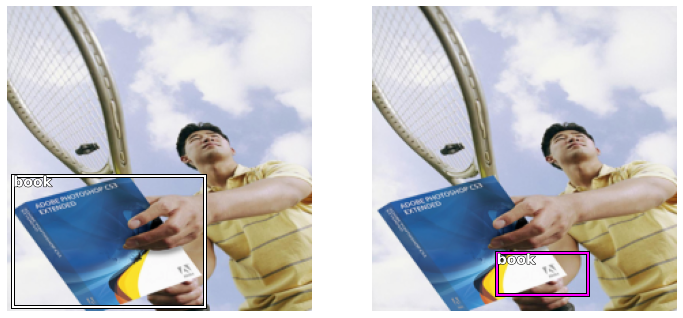

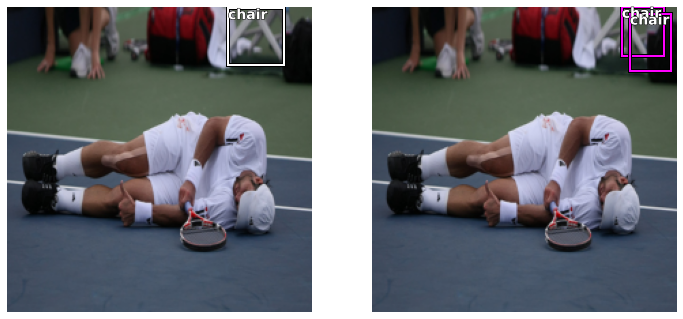

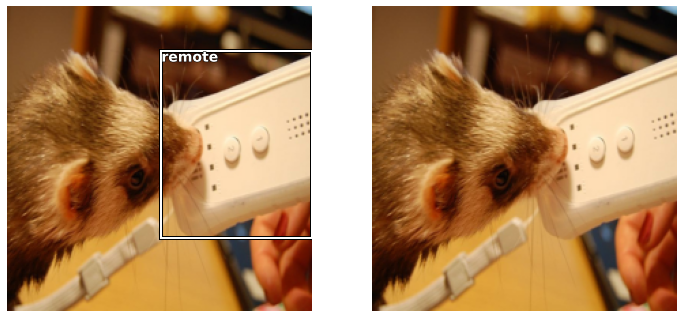

In [ ]:
lrn = load_learner('models/20201209_cocosample.pkl')
res = ResultShower(dls, lrn, anchors, box_size)
res(3)

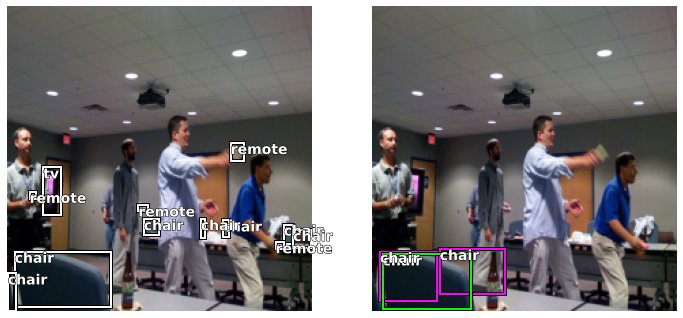

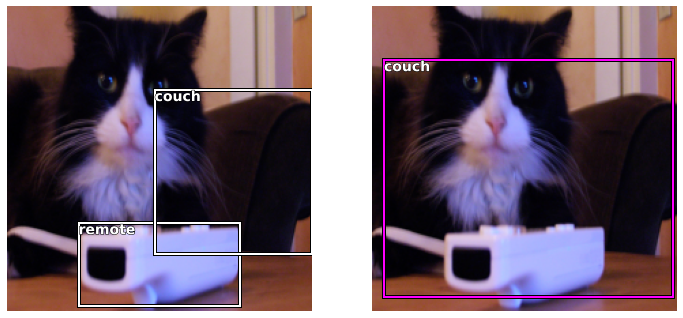

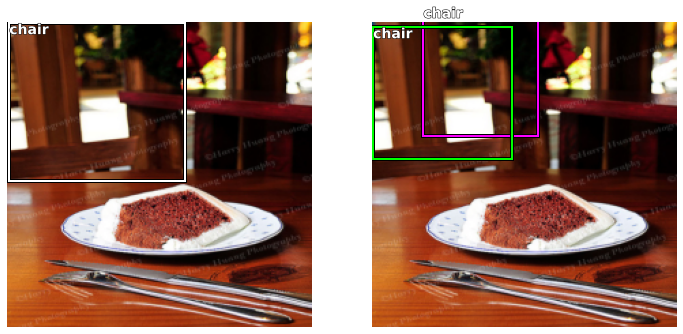

In [ ]:
res(3)

These results are not good. Something must be off.

## Investigating low performance

I think something is off because I was able to get OK results by training the same architecture on 50% of the entire COCO dataset (55k training ims). My intuition is that it would be harder to train a model to detect 80 different classess of objects on 55k ims than training a model to det 6 cls of objs on 22k ims.

What I'm noticing about the visualized results:
- Almost zero predictions for remotes
- Possibly fewer predictions in general (fewer FPs and FNs)

### Deeper architecture?

I don't think this is the problem, but I'm almost done solving it so I'll go ahead and do it.

The last layer of rn34 has an output as follows:

In [ ]:
body34 = create_body(resnet34, pretrained=True)
just_body34 = Learner(dls, body34, loss_func=ssd_loss)
just_body34.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     True      
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 64 x 64 x 56 x 56    0          False     
_________________________________________________

The last layer of rn50 has this output:

In [ ]:
body50 = create_body(resnet50, pretrained=True)
just_body50 = Learner(dls, body50, loss_func=ssd_loss)
just_body50.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    4,096      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     True      
_________________________________________________

What layer will take the [64 x 2048 x 7 x 7] to a [64 x 512 x 7 x 7]?

In [ ]:
bims, bbbs, blbls = next(iter(dls.train))

In [ ]:
t = body50(bims)
t.shape

torch.Size([64, 2048, 7, 7])

Will a conv2d work?

In [ ]:
fconv = nn.Conv2d(2048, 512, 3, padding=1)
u = fconv(t.cpu())
u.shape

torch.Size([64, 512, 7, 7])

Yes!!! I can use my StdConv w/ stride=1 to get the same result and reuse code.

In [ ]:
StdConv(2048, 512, stride=1)(t.cpu()).shape

torch.Size([64, 512, 7, 7])

I made two changes to SSDHead to make it fit the resnet50:
1. I added the extra StdConv (seen above)
2. I removed the first ReLU in the forward

In [ ]:
class SSDHead50(Module):
    """Wraps StdConv and OutConv into a head module."""
    def __init__(self, k, bias, drop):
        super().__init__()
        self.drop  = nn.Dropout(drop)
        self.conv_rn50 = StdConv(2048, 512, stride=1) # ADDED
        
        self.conv0 = StdConv(512,256, drop=drop) # most grid cells (4x4 for sz=224)
        self.out0  = OutConv(k,  256, bias)
        self.conv1 = StdConv(256,256, drop=drop)
        self.out1  = OutConv(k,  256, bias)
        self.conv2 = StdConv(256,256, drop=drop) # fewest grid cells (1x1 for sz=224)
        self.out2  = OutConv(k,  256, bias)
        
    def forward(self, x):
        x = self.drop(x)      # REMOVED ReLU(x)
        x = self.conv_rn50(x) # ADDED layer
        x = self.conv0(x)
        bb0,lbl0 = self.out0(x)
        x = self.conv1(x)
        bb1,lbl1 = self.out1(x)
        x = self.conv2(x)
        bb2,lbl2 = self.out2(x)
        return [torch.cat([ bb0, bb1, bb2], dim=1),
                torch.cat([lbl0,lbl1,lbl2], dim=1)]

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=0.0020892962347716093)

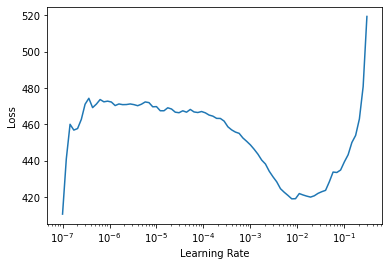

In [ ]:
model = CustomModule(create_body(resnet50, pretrained=True),
                     SSDHead50(k, -4., drop=.4))
learner = Learner(dls, model, loss_func=ssd_loss).to_fp16()
learner.freeze()
learner.lr_find()

Since I'm using a batch size of 64 instead of 128, I'll have to multiply the valid_loss by 2 to get comparable results. That means I'm looking for an ending valid_loss of 225 or better.

In [ ]:
learner.fit_one_cycle(5, lr=2e-3)

epoch,train_loss,valid_loss,time
0,286.789612,301.806274,01:39
1,271.766907,272.478455,01:39
2,242.745956,245.962189,01:39
3,203.929123,226.759750,01:39
4,173.358093,224.428391,01:39


Good – not bad on the first try. I'll try again with more epochs to see if I can get a better fit:

In [ ]:
model = CustomModule(create_body(resnet50, pretrained=True),
                     SSDHead50(k, -4., drop=.4))
learner = Learner(dls, model, loss_func=ssd_loss).to_fp16()
learner.freeze()
learner.fit_one_cycle(10, lr=2e-3)

epoch,train_loss,valid_loss,time
0,278.004669,281.627136,01:38
1,272.964478,284.989288,01:37
2,264.457703,282.565521,01:37
3,248.039429,269.786224,01:37
4,222.924973,256.320129,01:37
5,195.589966,241.444427,01:37
6,162.473465,240.455215,01:37
7,139.766510,243.696121,01:37
8,120.455620,283.085999,01:33


KeyboardInterrupt: 

I'll try that one again later – it clearly had a hiccup at the beginning of the training session.

Now I'll try fine tune:

In [ ]:
model = CustomModule(create_body(resnet50, pretrained=True),
                     SSDHead50(k, -4., drop=.4))
learner = Learner(dls, model, loss_func=ssd_loss).to_fp16()
learner.fine_tune(8, base_lr=2e-3)

epoch,train_loss,valid_loss,time


I'll now try using a lower dropout (.1 instead of .4). I actually don't really know what effect this is having on my training – according to JH, it will prevent overfitting while decreasing min possible loss, but the tradeoff is worth it.

In [ ]:
model = CustomModule(create_body(resnet50, pretrained=True),
                     SSDHead50(k, -4., drop=.1))
learner = Learner(dls, model, loss_func=ssd_loss).to_fp16()
learner.freeze()
learner.fit_one_cycle(8, lr=2e-3)